# P1C3 : Le Pseudo-Labeling, ou l'art de faire confiance √† son mod√®le (avec mod√©ration)

Bienvenue dans ce premier chapitre pratique ! Aujourd'hui, on s'attaque √† un classique de l'apprentissage semi-supervis√© : le **pseudo-labeling**. L'id√©e ? Si un mod√®le est suffisamment s√ªr de sa pr√©diction sur une image non √©tiquet√©e, pourquoi ne pas lui faire confiance et utiliser cette pr√©diction comme une "vraie" √©tiquette ?

> C'est un peu comme demander √† un √©l√®ve de corriger ses propres copies. Risqu√©, mais si on le guide bien, √ßa peut marcher !

**Objectifs du jour :**
1. Entra√Æner un premier mod√®le sur tr√®s peu de donn√©es.
2. Utiliser ce mod√®le pour g√©n√©rer des pseudo-labels sur des donn√©es non √©tiquet√©es.
3. Impl√©menter la boucle de pseudo-labeling pour r√©-entra√Æner le mod√®le.
4. Comprendre l'importance du **seuil de confiance** et de la **calibration**.

## 1. Pr√©paration de l'environnement et des donn√©es

On commence par les bases : importer les librairies et charger notre dataset, `DermaMNIST`. C'est un jeu de donn√©es d'images de l√©sions cutan√©es. Notre mission : les classifier correctement, m√™me avec une poign√©e d'√©tiquettes.

DermaMNIST fait partie de la famille des datasets **MedMNIST**, une collection standardis√©e de datasets d'images m√©dicales, tous au format 28x28 et organis√©s de mani√®re similaire aux c√©l√®bres datasets MNIST. L'objectif de MedMNIST est de faciliter la recherche et la comparaison de mod√®les d'apprentissage automatique sur des t√¢ches m√©dicales.

Le dataset DermaMNIST est bas√© sur le HAM10000, une large collection d'images de dermatoscopie. Il contient des images de 7 classes diff√©rentes de l√©sions cutan√©es. Son int√©r√™t p√©dagogique est majeur : il permet d'aborder des probl√®mes de classification d'images m√©dicales avec un dataset de taille raisonnable, tout en simulant des sc√©narios de faible quantit√© de donn√©es √©tiquet√©es, parfait pour explorer des techniques comme le pseudo-labeling.

Les 7 classes de l√©sions cutan√©es sont :

    0: actinic keratoses and intraepithelial carcinoma
    1: basal cell carcinoma
    2: benign keratosis-like lesions
    3: dermatofibroma
    4: melanoma
    5: melanocytic nevi
    6: vascular lesions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import transforms
import medmnist
from medmnist import INFO, Evaluator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Pour la reproductibilit√©, parce qu'on est des gens s√©rieux
torch.manual_seed(42)
np.random.seed(42)

### Chargement du dataset DermaMNIST

La librairie `medmnist` nous simplifie la vie. On t√©l√©charge les donn√©es et on les pr√©pare.

In [2]:
# Nom du dataset √† charger
data_flag = 'dermamnist'
# R√©cup√®re les informations sp√©cifiques √† ce dataset depuis medmnist
info = INFO[data_flag]

# Ajout de prints pour mieux comprendre le dataset
print(f"Dataset charg√© : {data_flag}")

# Extrait le type de t√¢che (classification, r√©gression, etc.)
task = info['task']
print(f"Type de t√¢che : {task}")

# Extrait le nombre de canaux des images (3 pour RGB, 1 pour niveaux de gris)
n_channels = info['n_channels']
print(f"Nombre de canaux : {n_channels}")

# Extrait le nombre de classes pour la classification
n_classes = len(info['label'])
print(f"Nombre de classes : {n_classes}")

# R√©cup√®re la classe Python sp√©cifique pour ce dataset
DataClass = getattr(medmnist, info['python_class'])

# Transformations √† appliquer aux images :
# 1. transforms.ToTensor() : Convertit les images PIL en tensors PyTorch (scalaire entre 0 et 1)
# 2. transforms.Normalize() : Normalise les tensors avec la moyenne et l'√©cart-type sp√©cifi√©s
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]) # Normalisation standard pour les images
])

# Charge les datasets d'entra√Ænement et de test en appliquant les transformations et en t√©l√©chargeant si n√©cessaire
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

print(f"Taille du jeu d'entra√Ænement : {len(train_dataset)}")
print(f"Taille du jeu de test : {len(test_dataset)}")

Dataset charg√© : dermamnist
Type de t√¢che : multi-class
Nombre de canaux : 3
Nombre de classes : 7
Taille du jeu d'entra√Ænement : 7007
Taille du jeu de test : 2005


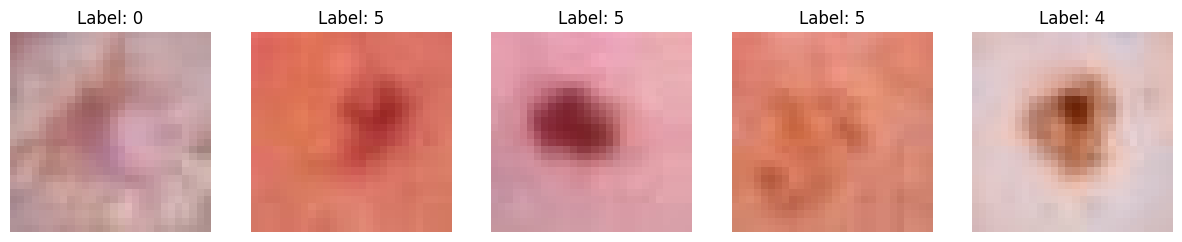

In [3]:
# Visualisation de quelques exemples
num_examples = 5
fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))

for i in range(num_examples):
    # R√©cup√®re une image et son label
    image, label = train_dataset[i]
    # L'image est un tensor, on le convertit en numpy array et on le transpose pour l'affichage
    # On d√©normalise aussi l'image pour un affichage correct
    img = image.numpy().transpose(1, 2, 0) * 0.5 + 0.5
    axes[i].imshow(img.squeeze(), cmap='gray') # Use cmap='gray' for single channel images if needed
    axes[i].set_title(f"Label: {label.item()}")
    axes[i].axis('off')

plt.show()

### Cr√©ation des jeux de donn√©es : √âtiquet√© vs. Non-√©tiquet√©

C'est ici que la magie du semi-supervis√© op√®re. On va simuler une situation o√π on a tr√®s peu de donn√©es √©tiquet√©es et un grand volume de donn√©es dont on ignore la classe.

On va prendre seulement **50 images par classe** pour l'entra√Ænement √©tiquet√© (350 images au total). Le reste du jeu d'entra√Ænement sera notre vivier de donn√©es non-√©tiquet√©es.

In [4]:
# On prend tout le set d'entra√Ænement initial
all_indices = list(range(len(train_dataset)))
labels_array = np.array(train_dataset.labels).flatten()

# S√©lectionner 50 images par classe
labeled_indices = []
for c in range(n_classes):
    class_indices = np.where(labels_array == c)[0]
    selected = np.random.choice(class_indices, min(50, len(class_indices)), replace=False)
    labeled_indices.extend(selected)

# Les indices non √©tiquet√©s sont le reste
unlabeled_indices = list(set(all_indices) - set(labeled_indices))

# Cr√©ation des Subsets PyTorch
labeled_dataset = Subset(train_dataset, labeled_indices)
unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

print(f"Taille du jeu de donn√©es √©tiquet√© : {len(labeled_dataset)}")
print(f"Taille du jeu de donn√©es non-√©tiquet√© : {len(unlabeled_dataset)}")
print(f"Taille du jeu de test : {len(test_dataset)}")

# DataLoaders
labeled_loader = DataLoader(dataset=labeled_dataset, batch_size=16, shuffle=True)
unlabeled_loader = DataLoader(dataset=unlabeled_dataset, batch_size=128, shuffle=False) # Pas besoin de shuffle ici
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Taille du jeu de donn√©es √©tiquet√© : 350
Taille du jeu de donn√©es non-√©tiquet√© : 6657
Taille du jeu de test : 2005


Distribution des classes dans le 'labeled_dataset' (350 images) :

Classe 0 (actinic keratoses and intraepithelial carcinoma): 50 images
Classe 1 (basal cell carcinoma): 50 images
Classe 2 (benign keratosis-like lesions): 50 images
Classe 3 (dermatofibroma): 50 images
Classe 4 (melanoma): 50 images
Classe 5 (melanocytic nevi): 50 images
Classe 6 (vascular lesions): 50 images


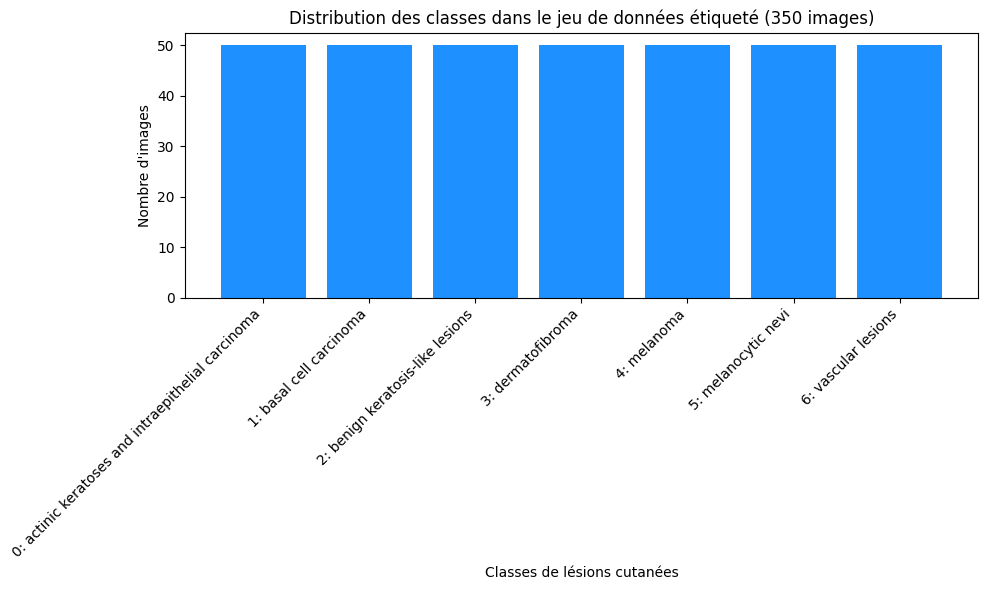

In [5]:
# Les labels du dataset complet sont dans train_dataset.labels
# On r√©cup√®re les labels correspondant aux indices de notre jeu √©tiquet√©
labels_of_labeled_set = train_dataset.labels[labeled_indices]

# Compter le nombre d'occurrences de chaque classe
class_counts = np.bincount(np.array(labels_of_labeled_set).flatten(), minlength=n_classes)
class_names = [f'{i}: {name}' for i, name in info['label'].items()]

# Afficher les comptes
print("Distribution des classes dans le 'labeled_dataset' (350 images) :\n")
for i, count in enumerate(class_counts):
    # R√©cup√©rer le nom complet de la classe
    full_class_name = info['label'][str(i)]
    print(f"Classe {i} ({full_class_name}): {count} images")

# Cr√©er un graphique √† barres pour visualiser la distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='dodgerblue')
plt.xlabel('Classes de l√©sions cutan√©es')
plt.ylabel("Nombre d'images")
plt.title("Distribution des classes dans le jeu de donn√©es √©tiquet√© (350 images)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2. Le Mod√®le de Base (Supervis√©)

On va d'abord entra√Æner un mod√®le simple (un petit CNN) uniquement sur nos 350 images √©tiquet√©es. On s'attend √† une performance... modeste. C'est notre point de d√©part.

In [6]:
# D√©finition d'un petit CNN (vous pouvez l'am√©liorer !)
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

# D√©finir le device (√† mettre au d√©but de votre code si ce n'est pas d√©j√† fait)
device = torch.device("cpu")

# On instancie la loss (sans poids car dataset √©quilibr√©)
criterion = nn.CrossEntropyLoss()

# On d√©place aussi le mod√®le sur le device
model = SimpleCNN(in_channels=n_channels, num_classes=n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Boucle d'entra√Ænement et d'√©valuation

Rien de nouveau sous le soleil ici, c'est une boucle d'entra√Ænement PyTorch standard. On va l'encapsuler dans une fonction pour la r√©utiliser.

In [7]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    """Entra√Æne et √©value un mod√®le."""
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # √âvaluation
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            y_true = torch.cat((y_true, labels), 0)
            y_score = torch.cat((y_score, outputs), 0)

    y_true = y_true.squeeze().cpu().numpy()
    evaluator = Evaluator(data_flag, 'test')
    metrics = evaluator.evaluate(y_score.detach().cpu().numpy())
    f1 = f1_score(y_true, y_score, average='macro')

    print(f'AUC: {metrics[0]:.3f}, Accuracy: {metrics[1]:.3f}, F1: {f1}')
    return metrics + f1

print("Entra√Ænement du mod√®le de base sur 350 images √©tiquet√©es...")
baseline_metrics = train_and_evaluate(model, labeled_loader, test_loader, optimizer, criterion)

Entra√Ænement du mod√®le de base sur 350 images √©tiquet√©es...


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

## 3. Le Pseudo-Labeling √† la rescousse !

Le score de base est probablement... bof. C'est normal !
Maintenant, on va mettre en place la boucle de pseudo-labeling.

**Le principe :**
1. **Pr√©dire** sur les donn√©es non √©tiquet√©es.
2. **S√©lectionner** les pr√©dictions o√π le mod√®le est le plus confiant (au-dessus d'un certain `seuil`).
3. **Ajouter** ces pr√©dictions (images + pseudo-labels) au jeu d'entra√Ænement √©tiquet√©.
4. **R√©-entra√Æner** le mod√®le sur ce nouveau jeu de donn√©es augment√©.
5. R√©p√©ter !

G√©n√©ration des pseudo-labels :
1. Parcourir le `unlabeled_loader`.
2. Obtenir les pr√©dictions du mod√®le.
3. Appliquer un `softmax` pour avoir des probabilit√©s.
4. Identifier la probabilit√© maximale (`probs`) et la classe pr√©dite (`preds`) pour chaque image.
5. Ne garder que les images o√π `probs` est sup√©rieur au `threshold`.
6. Retourner les indices de ces images et leurs pseudo-labels.

In [ ]:
def get_pseudo_labels(model, unlabeled_loader, threshold=0.95):
    """G√©n√®re des pseudo-labels pour les donn√©es o√π le mod√®le est confiant."""
    model.eval()
    pseudo_labeled_indices = []
    pseudo_labels = []

    with torch.no_grad():
        for i, (images, _) in enumerate(unlabeled_loader):
            # D√©placer les images sur le m√™me appareil que le mod√®le (GPU si disponible)
            images = images.to(next(model.parameters()).device)

            # 1. Obtenir les pr√©dictions (logits)
            outputs = model(images)

            # 2. Calculer les probabilit√©s (softmax)
            probabilities = torch.softmax(outputs, dim=1)

            # 3. Obtenir la proba max et la classe pr√©dite
            max_probs, predicted_classes = torch.max(probabilities, dim=1)

            # 4. Filtrer selon le seuil
            confident_mask = max_probs > threshold

            # 5. R√©cup√©rer les indices et les labels
            # Les indices dans le DataLoader ne correspondent pas aux indices dans le dataset original
            # Il faut donc calculer les indices r√©els dans le unlabeled_dataset
            batch_start_index = i * unlabeled_loader.batch_size
            original_indices_in_unlabeled_dataset = torch.arange(batch_start_index, batch_start_index + images.size(0))

            # On utilise les indices originaux dans le unlabeled_dataset pour acc√©der aux indices dans le train_dataset complet
            original_indices = [unlabeled_loader.dataset.indices[j] for j in original_indices_in_unlabeled_dataset[confident_mask]]

            confident_labels = predicted_classes[confident_mask]


            pseudo_labeled_indices.extend(original_indices)
            pseudo_labels.extend(confident_labels.tolist())

    print(f"Nombre d'images pour lesquelles le mod√®le est confiant (> {threshold:.2f}) : {len(pseudo_labeled_indices)}")
    return pseudo_labeled_indices, pseudo_labels

### La grande boucle de pseudo-labeling

Maintenant, on assemble tout. On va faire plusieurs it√©rations de pseudo-labeling.

In [ ]:
# On r√©initialise le mod√®le et l'optimiseur
ssl_model = SimpleCNN(in_channels=n_channels, num_classes=n_classes).to(device)
ssl_optimizer = torch.optim.Adam(ssl_model.parameters(), lr=0.001)

# On commence avec le jeu de donn√©es √©tiquet√© de base
current_labeled_indices = list(labeled_indices)

for iteration in range(5): # 5 it√©rations de pseudo-labeling
    print(f'--- It√©ration {iteration+1} ---')

    # On cr√©e le dataset d'entra√Ænement actuel
    iter_dataset = Subset(train_dataset, current_labeled_indices)
    iter_loader = DataLoader(iter_dataset, batch_size=32, shuffle=True)

    # 1. Entra√Æner le mod√®le
    print(f'Entra√Ænement sur {len(iter_dataset)} images...')
    pseudo_label_auc, pseudo_label_acc, pseudo_label_f1 = train_and_evaluate(ssl_model, iter_loader, test_loader, ssl_optimizer, criterion, epochs=5)

    # 2. G√©n√©rer des pseudo-labels
    print('G√©n√©ration de pseudo-labels...')
    pseudo_indices, pseudo_labels = get_pseudo_labels(ssl_model, unlabeled_loader, threshold=0.9)
    print(f'{len(pseudo_indices)} nouveaux pseudo-labels ajout√©s.')

    # 3. Mettre √† jour le dataset d'entra√Ænement
    temp_dataset = train_dataset
    for idx, label in zip(pseudo_indices, pseudo_labels):
        # On ne modifie que les labels des images qu'on a pseudo-√©tiquet√©es
        if idx not in current_labeled_indices: # Pour ne pas √©craser les vrais labels
            temp_dataset.labels[idx] = label
            current_labeled_indices.append(idx)

    if len(pseudo_indices) == 0:
        print("Plus de pseudo-labels trouv√©s, on arr√™te l√† !")
        break

In [ ]:
# Chemin o√π sauvegarder le mod√®le
model_save_path = 'dermamnist_ssl_model.pth'

# On sauvegarde uniquement les poids du mod√®le (c'est la meilleure pratique)
torch.save(ssl_model.state_dict(), model_save_path)

print(f"Mod√®le sauvegard√© avec succ√®s dans : {model_save_path}")

## 4. Analyse et Questions de R√©flexion

A-t-on am√©lior√© le score ? Normalement, oui ! Mais √† quel prix ?

**Questions pour aller plus loin :**
1. **L'impact du seuil** : Que se passe-t-il si vous baissez le seuil √† 0.8 ? Et si vous l'augmentez √† 0.99 ? Un seuil bas risque d'introduire du bruit (mauvais labels), un seuil haut risque de ne s√©lectionner que les exemples "faciles".
2. **La d√©rive de confirmation** : Le mod√®le devient de plus en plus confiant dans ses propres erreurs. Comment pourrait-on limiter ce ph√©nom√®ne ? (Indice : calibration, r√©gularisation...)
3. **Calibration du mod√®le** : Un mod√®le bien calibr√© donne des probabilit√©s qui refl√®tent sa confiance r√©elle. Un score de 0.8 devrait signifier "correct dans 80% des cas". Est-ce le cas ici ? Comment le v√©rifier ? (Indice : ECE, Brier score, diagrammes de fiabilit√©). C'est un excellent sujet pour le chapitre 7 !

> **Le mot de la fin :** Le pseudo-labeling est une technique simple mais puissante. Son succ√®s d√©pend enti√®rement de la qualit√© des pseudo-labels. Dans les prochains chapitres, on verra des m√©thodes plus robustes pour s'assurer de ne pas propager les erreurs !

# P1C4 : La Propagation de Labels, ou l'art de juger une image par ses voisins 

Bienvenue dans cette nouvelle exp√©rience ! Dans le chapitre pr√©c√©dent sur le pseudo-labeling, on a vu que notre mod√®le pouvait devenir un peu trop s√ªr de lui et finir par tourner en rond, en se confortant dans ses propres erreurs. C'est le fameux **biais de confirmation** ! 

> C'est comme ne parler qu'√† des gens qui sont d'accord avec vous : on n'apprend plus rien de nouveau.

**Nos objectifs de super-d√©tective :**
1.  **Recruter un expert** : Charger le mod√®le qu'on a p√©niblement entra√Æn√© au pseudo-labeling pour qu'il nous aide.
2.  **Cartographier le terrain** : Utiliser cet expert pour extraire l'ADN de chaque image (ses *embeddings*).
3.  **Tisser une toile** : Construire un graphe o√π chaque image est un n≈ìud, connect√© √† ses plus proches voisins.
4.  **Laisser la magie op√©rer** : Regarder les √©tiquettes de nos 350 images connues se propager √† travers la toile pour deviner les autres.
5.  **Comparer les r√©sultats** : Est-ce que cette m√©thode de 'sagesse des foules' est meilleure que de faire confiance √† un seul mod√®le ? Le suspense est √† son comble !

## 1. Pr√©paration du terrain : On reprend (presque) les m√™mes !

On commence par importer nos outils et pr√©parer notre jeu de donn√©es `DermaMNIST`. On va recr√©er notre sc√©nario de d√©part : 350 images √©tiquet√©es (50 par classe) et des milliers d'autres qui attendent d'√™tre identifi√©es.

In [ ]:
# Chargement des donn√©es
data_flag = 'dermamnist'
info = INFO[data_flag]
n_classes = len(info['label'])
n_channels = info['n_channels']
DataClass = getattr(medmnist, info['python_class'])

# Transformations standard
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])])

# On charge le jeu d'entra√Ænement complet et le jeu de test
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

# On recr√©e notre situation de d√©part : 50 images par classe √©tiquet√©es, et le reste en attente
all_indices = list(range(len(train_dataset)))
labels_array = np.array(train_dataset.labels).flatten()

# S√©lectionner 50 images par classe
labeled_indices = []
for c in range(n_classes):
    class_indices = np.where(labels_array == c)[0]
    selected = np.random.choice(class_indices, min(50, len(class_indices)), replace=False)
    labeled_indices.extend(selected)

# Les indices non √©tiquet√©s sont le reste
unlabeled_indices = list(set(all_indices) - set(labeled_indices))

print(f'Taille totale du jeu d\'entra√Ænement : {len(train_dataset)} images')
print(f'Donn√©es √©tiquet√©es (nos indics ) : {len(labeled_indices)} images')
print(f'Donn√©es non-√©tiquet√©es (les myst√®res √† r√©soudre ) : {len(unlabeled_indices)} images')

## 2. Recruter notre expert : le mod√®le du chapitre pr√©c√©dent

Pour que la propagation de labels fonctionne, on a besoin de 'sentir' la similarit√© entre les images. Utiliser les pixels bruts serait un d√©sastre ! 

On va donc faire appel √† un sp√©cialiste : le `SimpleCNN` qu'on a entra√Æn√© dans le notebook `P1C3`. M√™me s'il n'√©tait pas parfait, il a d√©j√† appris √† extraire des caract√©ristiques pertinentes des images de peau. On va lui demander de nous fournir les **embeddings** : une sorte de r√©sum√© num√©rique, ou d'ADN, pour chaque image.

In [ ]:
# On d√©finit l'architecture de notre CNN. 
# ATTENTION : Elle doit √™tre IDENTIQUE √† celle du mod√®le sauvegard√© !
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Pour correspondre exactement au mod√®le de P1C3
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x, return_features=False):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        if return_features:
            return out  # Retourne les features avant la classification (dimension 1568)
        out = self.fc(out)
        return out

model = SimpleCNN(in_channels=n_channels, num_classes=n_classes)
model_path = 'dermamnist_ssl_model.pth'

try:
    state_dict = torch.load(model_path, map_location=device)
    # Les noms de couches correspondent exactement, on charge tout
    model.load_state_dict(state_dict)
    print(f'‚úÖ Mod√®le charg√© depuis : {model_path}')
except FileNotFoundError:
    print(f'üö® Oups ! Le fichier {model_path} est introuvable.')
    print('Veuillez d\'abord ex√©cuter le notebook P1C3 pour entra√Æner et sauvegarder le mod√®le.')
    raise

# On passe le mod√®le sur le bon appareil et en mode √©valuation
model.to(device)
model.eval()

## 3. Extraction des 'Coordonn√©es GPS' (Embeddings) 

Maintenant que notre expert est pr√™t, on va le faire passer sur **toutes** les images de notre jeu d'entra√Ænement (√©tiquet√©es ou non) pour obtenir leurs fameux embeddings. C'est comme cr√©er une carte d'identit√© pour chaque image.

In [ ]:
def get_embeddings(model, dataset, device):
    """Extrait les embeddings d'un dataset en utilisant un mod√®le."""
    model.eval()
    embeddings = []
    loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=2)
    
    with torch.no_grad():
        for images, _ in tqdm(loader, desc='Extraction des embeddings'):
            images = images.to(device)
            feats = model(images, return_features=True)
            embeddings.append(feats.cpu().numpy())
            
    return np.vstack(embeddings)

# On extrait les embeddings en utilisant notre mod√®le
all_embeddings = get_embeddings(model, train_dataset, device)

print(f'\nExtraction termin√©e ! On a obtenu {all_embeddings.shape[0]} embeddings de dimension {all_embeddings.shape[1]}.')

## 4. La Propagation des Rumeurs (de Labels) 

C'est le moment que vous attendiez tous ! On va utiliser l'algorithme `LabelSpreading` de scikit-learn.

Comment √ßa marche ?
1. Il prend tous nos embeddings et construit un graphe de similarit√© (notre fameuse toile ).
2. On lui donne les 350 √©tiquettes qu'on conna√Æt. Pour les autres, on met une √©tiquette sp√©ciale : `-1` (qui veut dire 'Je ne sais pas').
3. L'algorithme va alors 'propager' l'influence des √©tiquettes connues √† leurs voisins, puis aux voisins de leurs voisins, jusqu'√† ce que chaque image ait une √©tiquette probable.

C'est un processus d√©mocratique o√π chaque image est influenc√©e par sa communaut√© !

In [ ]:
# On pr√©pare le tableau des labels pour l'algorithme
labels_for_spreading = np.full(len(train_dataset), -1, dtype=int)
labels_for_spreading[labeled_indices] = labels_array[labeled_indices]

print(f'Verification : {np.sum(labels_for_spreading != -1)} labels sont connus. Parfait !')

# On instancie le mod√®le LabelSpreading
label_spreading_model = LabelSpreading(kernel='knn', n_neighbors=10, n_jobs=-1)

print('Propagation des labels en cours... C\'est le moment d\'aller prendre un caf√© ')
label_spreading_model.fit(all_embeddings, labels_for_spreading)
print('Propagation termin√©e ! Voyons ce qu\'on a trouv√©.')

# On r√©cup√®re les labels pr√©dits pour l'ensemble du dataset
predicted_labels = label_spreading_model.transduction_

## 5. Le Verdict : Alors, √ßa a march√© ? 

Le mod√®le a rempli tous les trous et a attribu√© une √©tiquette √† chaque image. Mais est-ce que ces pr√©dictions sont bonnes?

Pour le savoir, on va comparer les √©tiquettes pr√©dites pour les donn√©es *initialement non-√©tiquet√©es* avec leurs vraies √©tiquettes (qu'on avait cach√©es). C'est l'heure de v√©rit√© !

In [ ]:
# On prend les labels pr√©dits UNIQUEMENT pour les donn√©es qui √©taient non-√©tiquet√©es
unlabeled_predicted_labels = predicted_labels[unlabeled_indices]
# Et on r√©cup√®re leurs vrais labels pour comparer
unlabeled_true_labels = labels_array[unlabeled_indices]

# On calcule les m√©triques de performance
accuracy = accuracy_score(unlabeled_true_labels, unlabeled_predicted_labels)
propag_auc = roc_auc_score(unlabeled_true_labels, unlabeled_predicted_labels)
f1 = f1_score(unlabeled_true_labels, unlabeled_predicted_labels, average='macro')

print('---  R√©sultats de la Propagation de Labels  ---')
print(f' Accuracy sur les {len(unlabeled_indices)} images myst√®res : {accuracy:.3f}')
print(f' F1-score (macro) : {f1:.3f}')

# Rappel : le pseudo-labeling stagnait autour de 0.65 d'accuracy.
# Si on est au-dessus, c'est une victoire ! 

# On affiche la matrice de confusion pour voir o√π le mod√®le se trompe
cm = confusion_matrix(unlabeled_true_labels, unlabeled_predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(info['label'].values()))

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title('Matrice de confusion pour les pr√©dictions par propagation')
plt.show()

In [ ]:
from torch.utils.data import Dataset

# Cr√©er un dataset personnalis√© avec les labels propag√©s
class PropagatedDataset(Dataset):
    def __init__(self, dataset, labels):
        self.dataset = dataset
        self.labels = labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Ignore les labels d'origine, img est d√©j√† un tenseur transform√©
        label = self.labels[idx]
        return img, label

# Cr√©er le nouveau dataset avec les labels propag√©s
train_dataset_propagated = PropagatedDataset(train_dataset, predicted_labels)

# Cr√©er un DataLoader pour l'entra√Ænement
train_loader_propagated = DataLoader(train_dataset_propagated, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
# D√©finir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Entra√Ænement du mod√®le de base sur images √©tiquet√©es avec labels propag√©s...")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)
metrics = train_and_evaluate(model, train_loader_propagated, test_loader, optimizer, criterion)

print('Entra√Ænement termin√© !')

## 6. Conclusion et Questions pour la suite 

Normalement, vous devriez voir une **nette am√©lioration** par rapport au pseudo-labeling ! L'accuracy et le F1-score devraient √™tre plus √©lev√©s, et les graphiques t-SNE devraient montrer que les clusters de couleurs pr√©dits ressemblent beaucoup plus √† la v√©rit√© terrain.

La propagation de labels est puissante car elle exploite la **structure globale** des donn√©es, au lieu de se fier aux pr√©dictions isol√©es et parfois trop confiantes d'un seul mod√®le. 

**Mais on peut encore faire mieux ! Voici quelques questions pour ouvrir sur les prochains chapitres :**

1. **La qualit√© des embeddings** : On a utilis√© un petit CNN entra√Æn√© sur peu de donn√©es. Que se passerait-il si on utilisait un mod√®le beaucoup plus puissant, comme un **ResNet pr√©-entra√Æn√© sur des millions d'images (ImageNet)**, pour extraire nos embeddings ? La carte serait-elle plus pr√©cise ?

2. **Et si on cr√©ait de fausses images ?** On manque de donn√©es √©tiquet√©es. Et si, au lieu de deviner des labels, on demandait √† une IA de nous **g√©n√©rer de nouvelles images** de l√©sions cutan√©es qui ressemblent aux vraies ? C'est le monde fascinant des **GANs (Generative Adversarial Networks)** que nous explorerons bient√¥t !

3. **Le meilleur des deux mondes ?** Peut-on combiner le pseudo-labeling et les approches par graphe ? (Indice : oui, et ce sont souvent les m√©thodes les plus performantes !)

# P1C5 : Les Semi-Supervised GANs, ou l'art de g√©n√©rer pour mieux classer

Bienvenue dans ce chapitre d√©di√© aux **Semi-Supervised Generative Adversarial Networks (SGANs)** ! Apr√®s avoir explor√© le pseudo-labeling (qui se fie aux pr√©dictions confiantes du mod√®le) et la propagation de labels (qui exploite les similarit√©s entre images via des graphes), on passe √† une approche plus 'cr√©ative' : utiliser des r√©seaux adversariaux pour g√©n√©rer de nouvelles donn√©es et am√©liorer la classification.

> Imaginez deux agents en comp√©tition : l'un (le g√©n√©rateur) cr√©e de fausses images pour tromper l'autre (le discriminateur), qui doit non seulement d√©tecter les faux, mais aussi classer les vraies images. Cette 'bataille' permet d'apprendre des repr√©sentations riches, m√™me avec peu de labels !

Les SGANs √©tendent les GANs classiques au semi-supervis√© : le discriminateur pr√©dit √† la fois 'vrai/faux' et la classe pour les images vraies. Cela permet d'utiliser les donn√©es non √©tiquet√©es pour renforcer l'apprentissage non supervis√© (vrai vs faux), et les √©tiquet√©es pour la supervision.

**Pourquoi SGAN ?** Dans les contextes comme DermaMNIST, o√π les labels sont rares et co√ªteux (besoin d'experts m√©dicaux), g√©n√©rer de donn√©es vari√©es aide le mod√®le √† mieux g√©n√©raliser sans ajouter de bruit comme dans le pseudo-labeling.

**Compr√©hension cl√© de la strat√©gie SGAN :**
- Pour les **donn√©es √©tiquet√©es** : On corrige le discriminateur (D) pour pr√©dire la bonne classe (0 √† 6) avec une perte supervis√©e, car on conna√Æt la v√©rit√©.
- Pour les **donn√©es non √©tiquet√©es** : On corrige D pour les classer comme 'r√©elles' (somme des probabilit√©s des classes 0 √† 6 √©lev√©e), sans pr√©ciser la classe exacte. C'est une correction 'binaire' : si D les place entre 0 et 6, c'est bien ; si en 7 ('faux'), c'est mal, car ce sont des images r√©elles.
- Pour les **images g√©n√©r√©es** (fausses) : On corrige D pour les classer comme 'fausses' (classe 7). Si D les place en 0 √† 6, c'est mal ; l'objectif est de maximiser la probabilit√© de la classe 7.
- Le **g√©n√©rateur (G)** veut l'inverse : tromper D en faisant passer ses fausses images pour r√©elles (probabilit√©s √©lev√©es en 0 √† 6).

**Objectifs p√©dagogiques :**
1. üß† Comprendre les GANs et leur adaptation au semi-supervis√©.
2. üõ†Ô∏è Impl√©menter un G√©n√©rateur et un Discriminateur simples.
3. ‚öîÔ∏è Mettre en place la boucle d'entra√Ænement adversariale.
4. üìä √âvaluer le Discriminateur comme classificateur et comparer aux m√©thodes pr√©c√©dentes.
5. üé® Visualiser les images g√©n√©r√©es pour voir ce que le mod√®le 'imagine'.

On r√©utilise notre setup de DermaMNIST avec 350 images √©tiquet√©es (50 par classe). Pr√™ts √† lancer la d√©mo ?

## 1. Pr√©paration de l'environnement et des donn√©es

On r√©utilise le code de chargement de DermaMNIST des chapitres pr√©c√©dents. Si vous avez saut√© les √©tapes, ex√©cutez d'abord P1C3 ou P1C4 pour avoir les variables comme `train_dataset`, `labeled_indices`, etc. Ici, on assume qu'elles sont d√©finies.

Rappel de la strat√©gie SGAN : Les donn√©es √©tiquet√©es servent √† la perte supervis√©e (correction pr√©cise sur la classe connue), les non √©tiquet√©es √† la perte non supervis√©e (correction pour 'r√©el', i.e. classes 0-6), et les g√©n√©r√©es √† renforcer la d√©tection des faux (classe 7).

In [ ]:
# Loaders pour SGAN (batch_size plus petit pour stabilit√©)
sgan_labeled_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
sgan_unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## 2. D√©finition des r√©seaux : G√©n√©rateur et Discriminateur

Le **G√©n√©rateur (G)** prend du bruit al√©atoire (vecteur de dimension 100) et produit des images 28x28x3.

Le **Discriminateur (D)** est une variante de notre SimpleCNN : il sort `n_classes + 1` logits (les n_classes premi√®res pour les classes r√©elles, la derni√®re pour 'faux').

Rappel : Lors de l'entra√Ænement, D sera corrig√© diff√©remment selon le type d'image :
- √âtiquet√©es : Pr√©dire la classe exacte (0-6).
- Non √©tiquet√©es : Pr√©dire 'r√©el' (somme probs 0-6 √©lev√©e).
- G√©n√©r√©es : Pr√©dire 'faux' (prob 7 √©lev√©e).

In [ ]:
# Dimension du bruit
z_dim = 100

class Generator(nn.Module):
    def __init__(self, z_dim=z_dim, img_channels=3, img_size=28):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_size * img_size * img_channels),
            nn.Tanh()  # Sorties entre -1 et 1
        )
        self.img_size = img_size
        self.img_channels = img_channels

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), self.img_channels, self.img_size, self.img_size)
        return img

class Discriminator(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes + 1)  # +1 pour faux

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Instanciation
G = Generator().to(device)
D = Discriminator(n_channels, n_classes).to(device)

# Optimiseurs
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

print('R√©seaux SGAN pr√™ts pour la d√©mo !')

## 3. La boucle d'entra√Ænement adversariale

Lheart des GANs : une boucle o√π D et G s'affrontent.

Rappel de la strat√©gie :
- **Pour D sur √©tiquet√©es** : Perte supervis√©e pour pr√©dire la bonne classe (0-6).
- **Pour D sur non √©tiquet√©es** : Perte pour pr√©dire 'r√©el' (somme probs 0-6 √©lev√©e).
- **Pour D sur g√©n√©r√©es** : Perte pour pr√©dire 'faux' (prob 7 √©lev√©e).
- **Pour G** : Perte pour tromper D (faire passer les g√©n√©r√©es pour r√©elles, somme probs 0-6 √©lev√©e).

L'entra√Ænement est altern√©. Observez les pertes pour voir l'√©quilibre.

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 100  # Ajustez pour la d√©mo (plus = mieux, mais plus long)
supervised_criterion = nn.CrossEntropyLoss()

# Listes pour stocker les pertes moyennes par √©poque
epoch_d_losses = []
epoch_g_losses = []

for epoch in tqdm(range(num_epochs), desc='Entra√Ænement SGAN'):
    D.train()
    G.train()
    d_losses = []
    g_losses = []

    # It√©rateurs pour √©quilibrer les batches
    labeled_iter = iter(sgan_labeled_loader)
    unlabeled_iter = iter(sgan_unlabeled_loader)

    num_batches = min(len(sgan_labeled_loader), len(sgan_unlabeled_loader))
    for batch_idx in range(num_batches):
        # Donn√©es √©tiquet√©es
        try:
            labeled_imgs, labels = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(sgan_labeled_loader)
            labeled_imgs, labels = next(labeled_iter)
        labeled_imgs = labeled_imgs.to(device)
        labels = labels.squeeze().long().to(device)

        # Donn√©es non √©tiquet√©es
        try:
            unlabeled_imgs, _ = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(sgan_unlabeled_loader)
            unlabeled_imgs, _ = next(unlabeled_iter)
        unlabeled_imgs = unlabeled_imgs.to(device)
        batch_size = unlabeled_imgs.size(0)

        # G√©n√©rer fausses images
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z)

        # --- Entra√Æner D ---
        d_optimizer.zero_grad()

        # Supervis√© sur r√©elles √©tiquet√©es : corriger pour la bonne classe (0-6)
        real_labeled_logits = D(labeled_imgs)
        d_sup_loss = supervised_criterion(real_labeled_logits[:, :n_classes], labels)

        # Non supervis√© sur r√©elles non √©tiquet√©es : corriger pour 'r√©el' (somme probs 0-6 √©lev√©e)
        real_unlabeled_logits = D(unlabeled_imgs)
        real_probs = torch.softmax(real_unlabeled_logits, dim=1)[:, :n_classes].sum(1)
        d_real_unsup_loss = -torch.log(real_probs + 1e-10).mean()

        # Non supervis√© sur fausses : corriger pour 'faux' (prob 7 √©lev√©e)
        fake_logits = D(fake_imgs.detach())
        fake_probs = torch.softmax(fake_logits, dim=1)[:, n_classes]
        d_fake_unsup_loss = -torch.log(fake_probs + 1e-10).mean()

        d_loss = d_sup_loss + d_real_unsup_loss + d_fake_unsup_loss
        d_loss.backward()
        d_optimizer.step()
        d_losses.append(d_loss.item())

        # --- Entra√Æner G : corriger pour tromper D (somme probs 0-6 √©lev√©e pour fausses) ---
        g_optimizer.zero_grad()

        fake_logits_g = D(fake_imgs)
        g_fake_probs = torch.softmax(fake_logits_g, dim=1)[:, :n_classes].sum(1)
        g_loss = -torch.log(g_fake_probs + 1e-10).mean()

        g_loss.backward()
        g_optimizer.step()
        g_losses.append(g_loss.item())

    # Calculer et stocker les pertes moyennes par √©poque
    epoch_d_losses.append(np.mean(d_losses))
    epoch_g_losses.append(np.mean(g_losses))

# Afficher le graphique des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_d_losses, label='Perte Discriminateur (D)', marker='o')
plt.plot(range(1, num_epochs + 1), epoch_g_losses, label='Perte G√©n√©rateur (G)', marker='s')
plt.xlabel('√âpoque')
plt.ylabel('Perte moyenne')
plt.title('√âvolution des pertes du Discriminateur et du G√©n√©rateur')
plt.legend()
plt.grid(True)
plt.show()

## 4. √âvaluation et comparaison

Utilisons le Discriminateur comme classificateur : on prend l'argmax sur les n_classes premi√®res sorties.

Rappel : Gr√¢ce √† la strat√©gie, D a √©t√© corrig√© sur les √©tiquet√©es (classes exactes), non √©tiquet√©es ('r√©el' vs 'faux'), et g√©n√©r√©es (d√©tection des faux). Cela devrait am√©liorer sa performance en classification.

Comparons avec les baselines des chapitres pr√©c√©dents (remplacez les placeholders par vos r√©sultats r√©els).

In [ ]:
def evaluate_sgan(model, test_loader, n_classes):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            logits = model(images)[:, :n_classes]
            preds = torch.argmax(logits, dim=1)
            y_true.extend(labels.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f'Accuracy SGAN: {acc:.3f}, F1-Score: {f1:.3f}')
    return acc, f1

sgan_acc, sgan_f1 = evaluate_sgan(D, test_loader, n_classes)

# Comparaison (remplacez par vos valeurs de P1C3/P1C4)
print('\n--- Comparaison ---')
print(f'Pseudo-Labeling - Acc: {pseudo_label_acc}, F1: {pseudo_label_f1}, AUC: {pseudo_label_auc}')
print(f'Label Propagation - Acc: {accuracy}, F1: {f1}, AUC: {propag_auc}')
print(f'SGAN - Acc: {sgan_acc:.3f}, F1: {sgan_f1:.3f}, AUC: {auc}')

## 5. Visualisation des images g√©n√©r√©es

Voyons ce que le G√©n√©rateur a appris ! On g√©n√®re quelques images al√©atoires.

Rappel : Ces images sont cr√©√©es pour tromper D, donc si elles ressemblent √† des l√©sions (et forcent D √† les classer en 0-6), G a bien fonctionn√©. Si D les classe en 7, il d√©tecte les faux efficacement.

In [ ]:
num_gen = 8
z = torch.randn(num_gen, z_dim).to(device)
gen_imgs = G(z).cpu().detach()
gen_imgs = (gen_imgs + 1) / 2  # D√©normaliser [0,1]

fig, axes = plt.subplots(1, num_gen, figsize=(15, 3))
for i in range(num_gen):
    axes[i].imshow(gen_imgs[i].permute(1, 2, 0).numpy())
    axes[i].axis('off')
    axes[i].set_title(f'Gen {i+1}')
plt.show()

## 6. Conclusion et Questions pour la suite

Les SGAN d√©montrent comment la g√©n√©ration adversariale peut enrichir l'apprentissage semi-supervis√© en cr√©ant de la vari√©t√©. Rappel de la strat√©gie : Correction pr√©cise sur √©tiquet√©es (classes 0-6), 'r√©el' sur non √©tiquet√©es (somme 0-6), 'faux' sur g√©n√©r√©es (classe 7). Le g√©n√©rateur trompe D pour am√©liorer les deux.

Si les images g√©n√©r√©es ressemblent √† des l√©sions cutan√©es, le mod√®le a captur√© des motifs utiles ! Comparez les scores : SGAN surpasse-t-il les m√©thodes pr√©c√©dentes ?

**Questions pour r√©fl√©chir :**
1. **Am√©liorations** : Comment rendre le SGAN conditionnel (cSGAN) pour g√©n√©rer par classe ? Utile pour √©quilibrer les minoritaires ?
2. **Stabilit√©** : Les GANs sont instables. Testez avec plus d'√©poques ou WGAN (Wasserstein loss). Qu'observez-vous ?
3. **Hybride** : Combinez SGAN avec pseudo-labeling : utilisez les fausses images comme non √©tiquet√©es suppl√©mentaires.

> **Fin de la d√©mo :** Vous avez vu SGAN en action ! Exp√©rimentez les hyperparam√®tres et comparez. Prochainement : d'autres tech comme les VAEs ou FixMatch.